In [1]:
# -*- coding: utf-8 -*-
import random
import numpy as np
import tensorflow as tf
import collections
import math
from six.moves import xrange
from konlpy.tag import Twitter
from six.moves import xrange

class Word2Vec:
    def load_file2(self,filesrc):
        datas = []
        f = open(filesrc, 'rt')
        while(True):
            data = f.readline()
            if not data: break
            datas.append(data)
        return datas

    def words_join(self,words):
        return " ".join(words).split(' ')
    
    def postaging(self,docs):
        twitter=Twitter()
        want = ['Exclamation','Adverb','Noun','Alpha','Verb','Adjective']
        stopword = ['어어','넷','만','것','타','최','태','개','홈','선','끼','각','번','하다','음','화', '이다',' ','다','더','포','제','저','여기','고','씬','첨','난','면','으루','네']
        pos = []
        
        for lines in docs[0]:
            strs=""
            for t in twitter.pos(lines, norm=True, stem=True):
                if (t[1] in want) and (t[0] not in stopword):
                    strs = strs + " " + t[0]  
            pos.append(strs[1:])
        
        return pos
    
    # word_list를 불러오기전 함수 
    #def __init__(self, word_list,vector_size,load_list):
    
    def __init__(self,vector_size,load_list,skip_window=3,num_steps=50001):
        #데이터 로드
        talk_list = []
        speak_list = []
        
        #load는 리스트 형태  , 한번에 여러문서도가능하도록 --> 나중에는 db형식으로 교체 필요
        talk_list.append(self.load_file2(load_list))
          
        # 포스테깅 및 stopword 처리 
        word_list = self.postaging(talk_list)
        
    
        
        #테스트 데이터로 확인식 보통 단어수 2000개를 넘지 못함 
        self.vocabulary_size = 4000# 원핫 인코딩 시킬 단어의 갯수   
        self.words = self.words_join(word_list)
        print("len(words) : ",len(self.words))
        
        self.data, self.count, self.dictionary, self.reverse_dictionary = self.build_dataset(self.words)
#         del words
        self.batch, self.labels = self.generate_batch(batch_size=8, num_skips=2, skip_window=1)
        self.batch_size = 32
        self.embedding_size = vector_size  # embedding vector의 크기. 아웃풋 크기 
        self.skip_window = skip_window     # 윈도우 크기 : 왼쪽과 오른쪽으로 얼마나 많은 단어를 고려할지를 결정.
        self.num_skips = 2         # 레이블(label)을 생성하기 위해 인풋을 얼마나 많이 재사용 할 것인지를 결정.
               
        self.num_sampled = 64    # sample에 대한 negative examples의 개수.
        self.num_steps = num_steps  # server 시 올리
        
        self.final_embeddings = self.train(self.reverse_dictionary,self.data)
        
        
    def output(self):
        return self.final_embeddings, self.data, self.count, self.dictionary, self.reverse_dictionary,self.words
      
        
    def train(self,reverse_dictionary,data):
        graph = tf.Graph()
        with graph.as_default():
        
          # 트레이닝을 위한 인풋 데이터들
          train_inputs = tf.placeholder(tf.int32, shape=[self.batch_size])
          train_labels = tf.placeholder(tf.int32, shape=[self.batch_size, 1])
        
          # Ops and variables pinned to the CPU because of missing GPU implementation
          with tf.device('/cpu:0'):
            # embedding vectors 행렬을 랜덤값으로 초기화
              embeddings = tf.Variable(
                    tf.random_uniform([self.vocabulary_size, self.embedding_size], -1.0, 1.0))
            # 행렬에 트레이닝 데이터를 지정
              embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        
              # NCE loss를 위한 변수들을 선언
              nce_weights = tf.Variable(tf.truncated_normal([self.vocabulary_size, self.embedding_size], stddev=1.0 / math.sqrt(self.embedding_size)))
              nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
        
          # batch의 average NCE loss를 계산한다.
          # tf.nce_loss 함수는 loss를 평가(evaluate)할 때마다 negative labels을 가진 새로운 샘플을 자동적으로 생성한다.
          loss = tf.reduce_mean(
              tf.nn.nce_loss(weights=nce_weights,
                             biases=nce_biases,
                             labels=train_labels,
                             inputs=embed,
                             num_sampled=self.num_sampled,
                             num_classes=self.vocabulary_size))
        
          optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
        
        
          # minibatch examples과 모든 embeddings에 대해 cosine similarity를 계산한다.
          norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
          normalized_embeddings = embeddings / norm

        with tf.Session(graph=graph) as session:
          # 트레이닝을 시작하기 전에 모든 변수들을 초기화한다.
            tf.initialize_all_variables().run()
            print("Initialized")
        
            average_loss = 0
            for step in xrange(self.num_steps):
                batch_inputs, batch_labels = self.generate_batch(self.batch_size, self.num_skips, self.skip_window)
                feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}
            
            # optimizer op을 평가(evaluating)하면서 한 스텝 업데이트를 진행한다.
                _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
                average_loss += loss_val
        
                if step % 2000 == 0:
                    if step > 0:
                        average_loss /= 2000
                    # 평균 손실(average loss)은 지난 2000 배치의 손실(loss)로부터 측정된다.
                    print("Average loss at step ", step, ": ", average_loss)
                    average_loss = 0
                
                final_embeddings = normalized_embeddings.eval(session=session)
                
        return final_embeddings
          
    
    def build_dataset(self,words):
      count = [['UNK', -1]]
      count.extend(collections.Counter(words).most_common(self.vocabulary_size - 1))
      dictionary = dict()
      for word, _ in count:
        dictionary[word] = len(dictionary)
      data = list()
      unk_count = 0
      for word in words:
        if word in dictionary:
          index = dictionary[word]
        else:
          index = 0  # dictionary['UNK']
          unk_count += 1
        data.append(index)
      count[0][1] = unk_count
      reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
      return data, count, dictionary, reverse_dictionary
    
    
    # Step 3: skip-gram model을 위한 트레이닝 데이터(batch)를 생성하기 위한 함수.
    def generate_batch(self,batch_size, num_skips, skip_window):
        data_index = 0
        #global data_index
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
        span = 2 * skip_window + 1 # [ skip_window target skip_window ]
        buffer = collections.deque(maxlen=span)
        
        for _ in range(span):
            buffer.append(self.data[data_index])
            data_index = (data_index + 1) % len(self.data)
        for i in range(batch_size // num_skips):
            target = skip_window  # target label at the center of the buffer
            targets_to_avoid = [ skip_window ]
            for j in range(num_skips):
                while target in targets_to_avoid:
                    target = random.randint(0, span - 1)
                targets_to_avoid.append(target)
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j, 0] = buffer[target]
            buffer.append(self.data[data_index])
            data_index = (data_index + 1) % len(self.data)
        return batch, labels


    def similarity(self,find_word,top_word):
        find_word_data = self.final_embeddings[self.dictionary[find_word]]
        sims = []
        for key,value in  self.dictionary.items():
            similarity = self.final_embeddings[value]
            cosine_similarity = np.dot(find_word_data, similarity)/(np.linalg.norm(find_word_data)* np.linalg.norm(similarity))
            sims.append([cosine_similarity,key])
        sims.sort(reverse=True)
        return sims[1:top_word+1]
    

E:\ananconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# import Word2Vec


#load = ["6CM00079.txt","6CM00080.txt","6CM00082.txt","6CM00083.txt","6CM00088.txt","6CM00090.txt","6CM00092.txt","6CM00093.txt","6CM00094.txt","6CM00095.txt"]
load = "sh_news3.txt"

# 호출 및 벡터 사이즈 설정 
vector_size = 10
skip_window = 5
num_steps = 50001
#word2vec = Word2Vec.Word2Vec(pos,vector_size)
word2vec = Word2Vec(vector_size,load,skip_window,num_steps)
final_embeddings, datas, count, dictionary, reverse_dictionary,words = word2vec.output()
# 유사한 단어 불러오기 
#print(dictionary)
# result = word2vec.similarity("군대",100)
# print(result)


len(words) :  598
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step  0 :  183.40322875976562
Average loss at step  2000 :  22.380530566692354
Average loss at step  4000 :  2.2880023366212843
Average loss at step  6000 :  2.2033072255253794
Average loss at step  8000 :  2.1533038818240167
Average loss at step  10000 :  2.1565039728879927
Average loss at step  12000 :  2.137233239352703
Average loss at step  14000 :  2.1202710683941843
Average loss at step  16000 :  2.107213544547558
Average loss at step  18000 :  2.1114550548791886
Average loss at step  20000 :  2.087931980013847
Average loss at step  22000 :  2.0804973002672194
Average loss at step  24000 :  2.059541780292988
Average loss at step  26000 :  2.0741274089217185
Average loss at step  28000 :  2.064943584024906
Average loss at step  30000 :  2.0755966670513155
Average loss at step  32000 :  2.070

# 군집 계산 작업

## 단어수 전체 벡터 - doc2vec 만들어서 비교 (doc size는 임시조절)

In [19]:
# load = "news3.txt"
load = "sh_news3.txt"
term = 10
doc_size = 100

cluster_word = []
# cluster_word = [words[i:i+doc_size] for i,v in  enumerate(words) if i+doc_size < len(words) and i%term == 0]
cluster_word = [words[i:i+doc_size] for i,v in  enumerate(words) if i+doc_size < len(words)]
# print("cluster_word[0] : ",cluster_word[0])
print(len(cluster_word))
print(len(words))
cluster_word_vector = []

for words_list in cluster_word:
    sum=[.0,.0,.0,.0,.0,.0,.0,.0,.0,.0]
    for v in [final_embeddings[dictionary[vector]] for vector in words_list]:
        sum = np.add(sum,v)
    cluster_word_vector.append(sum)

498
598


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
cluster_word_similarity =  cosine_similarity(cluster_word_vector,cluster_word_vector)

498
0


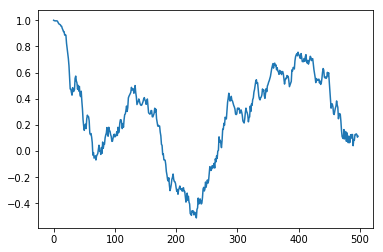

50


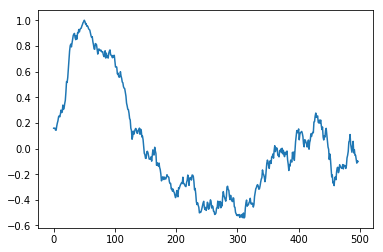

100


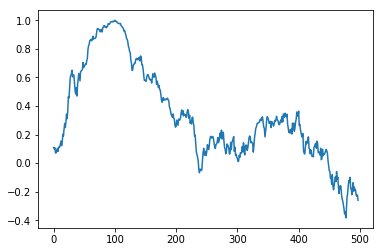

150


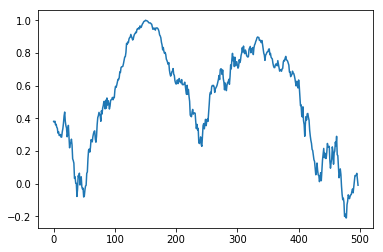

200


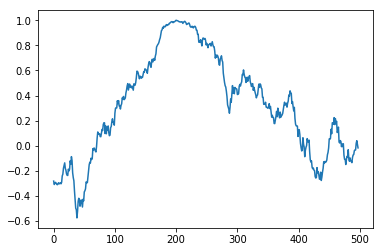

250


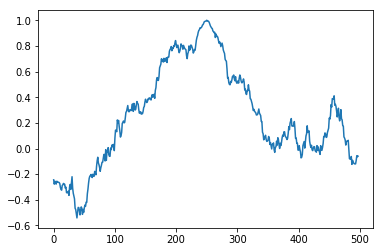

300


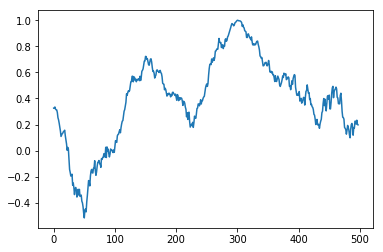

350


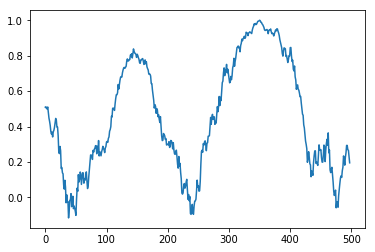

400


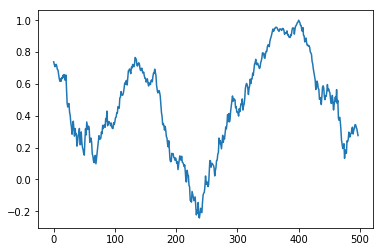

450


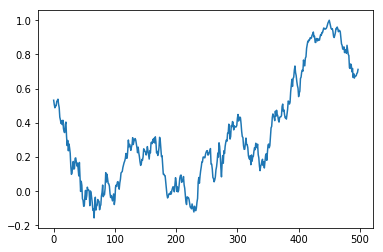

In [21]:
import matplotlib.pyplot as plt
print(len(cluster_word_similarity))
for i in range(0,len(cluster_word_similarity),50):
    print(i)
    plt.plot(cluster_word_similarity[i])
    plt.show()
# plt.plot(cluster_word_similarity[0])
# plt.show()
# plt.plot(cluster_word_similarity[1])
# plt.show()

In [12]:
cluster_word_similarity[:5]

array([[1.        , 0.99632521, 0.9960501 , ..., 0.12667104, 0.10627902,
        0.11385271],
       [0.99632521, 1.        , 0.99803718, ..., 0.13379404, 0.11564146,
        0.1184226 ],
       [0.9960501 , 0.99803718, 1.        , ..., 0.09699959, 0.07554691,
        0.07976556],
       [0.99486477, 0.99636431, 0.99769375, ..., 0.1302171 , 0.10625783,
        0.10961725],
       [0.99580261, 0.99803536, 0.99725969, ..., 0.13735464, 0.11497368,
        0.11761152]])

## 방법2

In [13]:
term = 10
doc_size = 100

cluster_word = []
# f = open(load, 'rt')
# cluster_word = [words[i:i+doc_size] for i,v in  enumerate(words) if i+doc_size < len(words) and i%term == 0]
# print(len(words))
cluster_word = [words[i:i+(doc_size+1)+1]  for i in  range(0,len(words),doc_size)]
# print("cluster_word[0] : ",cluster_word[0])
# print("cluster_word[1] : ",cluster_word[1])
# print(cluster_word)
cluster_word_vector = []

for words_list in cluster_word:
    sum=[.0,.0,.0,.0,.0,.0,.0,.0,.0,.0]
    for v in [final_embeddings[dictionary[vector]] for vector in words_list]:
        sum = np.add(sum,v)
    cluster_word_vector.append(sum)
    
# print(cluster_word_vector)

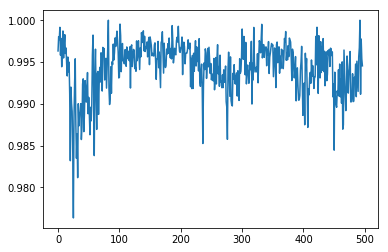

In [14]:
import matplotlib.pyplot as plt
# for i in range(0,len(cluster_word_similarity),10):
#     print(i)
#     plt.plot(cluster_word_similarity[i])
#     plt.show()
test = [v[i+1:i+2] for i,v in enumerate(cluster_word_similarity)]
plt.plot(test[:-1])
plt.show()


In [15]:
def load_file2(filesrc):
    datas = []
    f = open(filesrc, 'rt')
    while(True):
        data = f.readline()
        if not data: break
        datas.append(data)
    return datas

def words_join(words):
    return " ".join(words).split(' ')

def postaging(docs):
    twitter=Twitter()
    want = ['Exclamation','Adverb','Noun','Alpha','Verb','Adjective']
    stopword = ['어어','넷','만','것','타','최','태','개','홈','선','끼','각','번','하다','음','화', '이다',' ','다','더','포','제','저','여기','고','씬','첨','난','면','으루','네']
    
    pos = []
    
#     print(docs[0][1])
    for lines in docs[0]:
        strs = ""
        for t in twitter.pos(lines, norm=True, stem=True):
#             print(t)
            if (t[1] in want) and (t[0] not in stopword):
                strs = strs + " " + t[0]  
        pos.append(strs[1:])

    return pos


load = "sh_news3.txt"
#데이터 로드
talk_list = []
speak_list = []

#load는 리스트 형태  , 한번에 여러문서도가능하도록 --> 나중에는 db형식으로 교체 필요
talk_list.append(load_file2(load))
# print(talk_list)
# 포스테깅 및 stopword 처리 
word_list = postaging(talk_list)
print(word_list)

['앵커', '이번 주 여고괴담 시리즈 이후 오랜만 보이다 한국 학원 공포 영화 개봉', '이 함께 초고층빌딩 펼쳐지다 할리우드 액션 영화 흥행 대결 벌이다 예정', '개봉 영화 소식 송 형국 기자', '리포트', '수능 마치다 고등학생 외진 시골 여행 떠나다', '길 헤매다 이 버려진 놀이동산 이르다 무언가 끌리다 귀신 집 들어가다', '각자 개성 다른 명의 친구 위기 겪다 입시 진로 등 현실 걱정 공포 상황 겹 치다', '여고괴담 시리즈 이후 대다 신인 배우 등용문 통용 되다 학원 공포 영화 명맥 이 수 있다 기대 되다', '', '성공 외과의사 스티븐 가정 직장 남 부르다 없다 삶 살다 듯 보이다', '', '그 자꾸만 다가오다 의문 소년 마틴 스티븐 집도 수술 중 숨지다 환자 아들', '', '스티븐 마틴 친절하다 대하 자녀 알 수 없다 마비 증상 찾아오다 피 수 없다 선택 기로 놓이다', '', '지난해 칸국제영화제 각본 받다 이 영화 고대 그리스 로마 신화 현대 가져오다 다음 울다 겨자 먹기 선택 수 없다 인물 혼돈 상황 밀도 높다 화면 담다 내다', '', 'FBI 요원 활약 주인공 불의 사고 자리 물러나다 뒤 층 초고층빌딩 보안팀장 맡다', '', '평화롭다 빌딩 테러범 공격 가해 지고 주인공 가족 화염 속 고립 되다 이 구 위 사투 벌어지다', '', '할리우드 근육 질 스타 드웨 존슨 고공 액션 아 찌다 전개 되다', '앵커', '', '백두산 비롯 북한 관광 대한 기 대감 최근 들다 한층 높아지다 있다', '', '백두산 지금 어떻다 모습 간직 있다', '', '사계절 데 모이다 듯 백두산 여름 비경 송 형국 기자 전', '', '리포트', '', '여명 사이 태양 떠오르다', '', '산 정상 감싸다 구름 서서히 물러나다', '', '맑은 하늘 밑 자태 드러내다 천지 절정 이르다 파랑 빛 숨 벅차 오르다', '', '천지 정기 안다 장 폭포 기운 차다 떨어지다 보기 해도 시원하다 녹연담 폭포 발길 붙듭니', '', '모진 바람 속 백두산 

## 방법3

In [16]:
term = 5
doc_size = 200

cluster_word = []
# f = open(load, 'rt')
# cluster_word = [words[i:i+doc_size] for i,v in  enumerate(words) if i+doc_size < len(words) and i%term == 0]
# print(len(words))
cluster_word = [words[i:i+(doc_size+1)+1]  for i in  range(0,len(words),term) ]
# print("cluster_word[0] : ",cluster_word[0])
# print("cluster_word[1] : ",cluster_word[1])
# print(cluster_word)

cluster_word_vector = []

for words_list in cluster_word:
    sum=[.0,.0,.0,.0,.0,.0,.0,.0,.0,.0]
    for v in [final_embeddings[dictionary[vector]] for vector in words_list]:
        sum = np.add(sum,v)
    cluster_word_vector.append(sum)
    
print(len(cluster_word_vector))

120


[array([0.99716268]), array([0.98344234]), array([0.99033262]), array([0.99195423]), array([0.99189104])]
[[1.         0.99716268 0.98966056 ... 0.23796943 0.33772177 0.27340262]
 [0.99716268 1.         0.98344234 ... 0.26974071 0.36539568 0.27640566]
 [0.98966056 0.98344234 1.         ... 0.20641784 0.31254973 0.263971  ]
 ...
 [0.23796943 0.26974071 0.20641784 ... 1.         0.86615743 0.53094447]
 [0.33772177 0.36539568 0.31254973 ... 0.86615743 1.         0.35968705]
 [0.27340262 0.27640566 0.263971   ... 0.53094447 0.35968705 1.        ]]


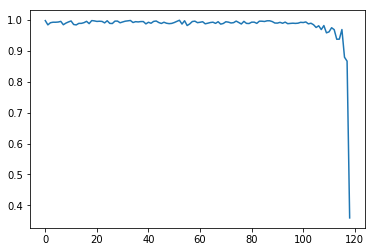

In [17]:
import matplotlib.pyplot as plt
cluster_word_similarity =  cosine_similarity(cluster_word_vector,cluster_word_vector)
test = [v[i+1:i+2] for i,v in enumerate(cluster_word_similarity)]

print(test[:5])
print(cluster_word_similarity)

plt.plot(test[:-1])
plt.show()

# test.index(min(test))